# Exploring Demographic Indicators

This notebook analyzes four datasets: [Life Expectancy](https://www.gapminder.org/tag/life-expectancy/), [Population](https://www.gapminder.org/data/documentation/gd003/), [Fertility Rate](https://www.gapminder.org/tag/fertility-rate/), and [Child Mortality](https://www.gapminder.org/data/documentation/gd005/) sourced from [Gapminder](https://www.gapminder.org/data/).
* **Life Expectancy** data represents the projected number of years a newborn child would live if current mortality patterns remain constant, with medium variant projections until 2100
* **Population** represents total number of people in a country
* **Fertility Rate** represents total birth per woman rate during her reproductive years (1960-2020)
* **Child Mortality Rate** represents total number of child deaths (ages 5 and below) for every 1,000 births

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
df_population = pd.read_csv('data/gapminder/population.csv', index_col=0)
df_life = pd.read_csv('data/gapminder/life_expectancy.csv', index_col=0)
df_fertility = pd.read_csv('data/gapminder/fertility_rate.csv', index_col=0)
df_child_mortality = pd.read_csv('data/gapminder/child_mortality.csv', index_col=0)

## Data Preparation

### Preprocessing and Merging

A summary of data preprocessing and merging operations in the code snipet below:
* Convert population values from strings to numbers to enable numerical calculations ("1M" to $10^7$)
* Reshape the dataframes from a wide format to a long format using the `melt` function to enable merging of the dataframes.
* Convert year and fertility rate values to integers and floats, respectively, for numerical calculations.
* Combine the dataframes to create a new dataframe with population, life expectancy, and fertility rate data - one starting from 1800 and another for 1960 since Fertility data is only available from 1960.

In [3]:
# Convert Strings to Numbers for Population Data
def convert_str_to_num(s):
    if 'M' in s:
        num = float(s[:-1]) * 1000000
    elif 'B' in s:
        num = float(s[:-1]) * 1000000000
    elif 'k' in s:
        num = float(s[:-1]) * 1000
    else:
        num = float(s)
    return num

df_population = df_population.applymap(convert_str_to_num)

# Reshaping the original dataframes from wide to long format
df_population = df_population.reset_index().melt(id_vars=['country'], var_name='year', value_name='pop')
df_life = df_life.reset_index().melt(id_vars=['country'], var_name='year', value_name='life')
df_fertility = df_fertility.reset_index().melt(id_vars=['country'], var_name='year', value_name='fert_rate')
df_child_mortality = df_child_mortality.reset_index().melt(id_vars=['country'], var_name='year', value_name='child_mort')

# Converting year column to integer in all dataframes
for df in [df_population, df_life, df_fertility, df_child_mortality]:
    df['year'] = df['year'].astype(int)

# Filtering the dataframes to only include data from 1960 onwards and merging the dataframes
df = pd.merge(df_population.loc[(df_population['year']>=1960)], 
              df_life.loc[(df_life['year']>=1960)], 
              on=['country', 'year'])
df = pd.merge(df, 
              df_fertility.loc[(df_fertility['year']>=1960)], 
              on=['country', 'year'])
df = pd.merge(df, 
              df_child_mortality.loc[(df_child_mortality['year']>=1960)], 
              on=['country', 'year'])

df = df.interpolate(method='linear', limit_direction='both')

#Checking the data
print(df.tail())

            country  year         pop  life  fert_rate  child_mort
11585         Samoa  2020    198000.0  70.5       3.79        14.9
11586         Yemen  2020  29800000.0  67.8       3.61        54.6
11587  South Africa  2020  59300000.0  64.3       2.36        32.1
11588        Zambia  2020  18400000.0  63.1       4.50        54.5
11589      Zimbabwe  2020  14900000.0  60.7       3.46        43.1


### Subregions Classification and Grouping

A summary of data aggregation operations performed:
* Assign subregion category to each country based on geographical proximity.
* Fill in any missing values using linear interpolation
* Aggregate the data by taking the sum of population and the mean of life expectancy, fertility rate, and child mortality rate for each subregion and year
* Calculates the median values for population, life expectancy, fertility rate, and child mortality rate for each year to provide a baseline for comparing the values of each subregion to its peers
* Assign binary values to compare if subregion's value is high or low compared to the median value of its peers

In [4]:
subregions = {
    'Africa-East': ['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Madagascar', 'Malawi', 'Mauritius', 'Mozambique', 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Tanzania', 'Uganda', 'Zambia', 'Zimbabwe'],
    'Africa-Middle': ['Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Congo Republic', 'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon', 'Sao Tome and Principe'],
    'Africa-North': ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Sudan', 'Tunisia', 'Western Sahara'],
    'Africa-South': ['Botswana', 'Eswatini', 'Lesotho', 'Namibia', 'South Africa'],
    'Africa-West': ['Benin', 'Burkina Faso', 'Cape Verde', 'Cote dIvoire', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo'],
    'America-Middle': ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama', 'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Cuba', 'Dominica', 'Dominican Republic', 'Grenada', 'Haiti', 'Jamaica', 'St. Kitts and Nevis', 'St. Lucia', 'St. Vincent and the Grenadines', 'Trinidad and Tobago'],
    'America-North': ['Canada', 'Mexico', 'United States', 'Greenland'],
    'America-South': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'],
    'Asia-East': ['China', 'Japan', 'Mongolia', 'North Korea', 'South Korea', 'Taiwan', 'Hong Kong', 'Macau'],
    'Asia-North-Middle': ['Kazakhstan', 'Kyrgyz Republic', 'Tajikistan', 'Turkmenistan', 'Uzbekistan', 'Russia'],
    'Asia-Pacific': ['Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru', 'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu'],
    'Asia-South': ['Afghanistan', 'Bangladesh', 'Bhutan', 'India', 'Iran', 'Maldives', 'Nepal', 'Pakistan', 'Sri Lanka'],
    'Asia-South-East': ['Brunei', 'Cambodia','Indonesia', 'Lao', 'Malaysia', 'Myanmar', 'Philippines', 'Singapore', 'Thailand', 'Timor-Leste', 'Vietnam'],
    'Asia-West': ['Armenia','Azerbaijan','Georgia', 'Turkey', 'Cyprus', 'Syria', 'Lebanon', 'Israel', 'Palestine', 'Jordan', 'Iraq','Oman','Yemen','Kuwait','Bahrain', 'Qatar', 'Saudi Arabia','United Arab Emirates'],
    'Europe-East': ['Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic', 'Estonia', 'Hungary', 'Latvia', 'Lithuania', 'Moldova', 'Montenegro', 'North Macedonia', 'Poland', 'Romania', 'Serbia', 'Slovak Republic', 'Slovenia', 'Ukraine'],
    'Europe-North': ['Denmark', 'Finland', 'Iceland', 'Norway', 'Sweden'],
    'Europe-South': ['Albania', 'Andorra', 'Greece', 'Italy', 'Malta', 'Monaco', 'Portugal', 'San Marino', 'Spain'],
    'Europe-West': ['Austria', 'Belgium', 'France', 'Germany', 'Ireland', 'Liechtenstein', 'Luxembourg', 'Netherlands', 'Switzerland', 'United Kingdom']
}

subregion_colors = {
    'Africa-East': (0.33725490196078434, 0.06274509803921569, 0.1803921568627451),
    'Africa-Middle': (0.43137254901960786, 0.047058823529411764, 0.21568627450980393),
    'Africa-North': (0.7294117647058823, 0.0784313725490196, 0.3607843137254902),
    'Africa-South': (0.9254901960784314, 0.27450980392156865, 0.5568627450980392),
    'Africa-West': (0.796078431372549, 0.30196078431372547, 0.6392156862745098),
    'America-Middle': (0.996078431372549, 0.8313725490196079, 0.42745098039215684),
    'America-North': (0.9882352941176471, 0.7176470588235294, 0.027450980392156862),
    'America-South': (0.8392156862745098, 0.6039215686274509, 0.0),
    'Asia-East': (0.5490196078431373, 0.7568627450980392, 0.5411764705882353),
    'Asia-North-Middle': (0.3176470588235294, 0.592156862745098, 0.30980392156862746),
    'Asia-Pacific': (0.17647058823529413, 0.32941176470588235, 0.17254901960784313), 
    'Asia-South': (0.7372549019607844, 0.8666666666666667, 0.47058823529411764),
    'Asia-South-East': (0.5647058823529412, 0.7529411764705882, 0.18823529411764706),
    'Asia-West': (0.3254901960784314, 0.43137254901960786, 0.10980392156862745),
    'Europe-East': (0.5294117647058824, 0.807843137254902, 0.9215686274509803),
    'Europe-North': (0.34509803921568627, 0.592156862745098, 0.8745098039215686),
    'Europe-South': (0.13333333333333333, 0.39215686274509803, 0.6941176470588235),
    'Europe-West': (0.1450980392156863, 0.2980392156862745, 0.4745098039215686)
}

In [5]:
# Assign subregion to each country
df['subregion'] = df['country'].map({country: subregion for subregion, countries in subregions.items() for country in countries})

# Check for countries without a matching subregion
missing_subregions = df[df['subregion'].isna()]['country'].unique()
print(f"The following countries do not have a matching subregion: {missing_subregions}")

# Summarize the data by subregion and year
df = df.groupby(['subregion', 'year']).agg({'pop': 'sum', 'life': 'mean','fert_rate':'mean','child_mort':'mean'}).reset_index()

# Adding median values for each subregion and year for comparison
df['median_pop'] = df.groupby('year')['pop'].transform('median').round(1)
df['median_life'] = df.groupby('year')['life'].transform('median').round(1)
df['median_fert'] = df.groupby('year')['fert_rate'].transform('median').round(1)
df['median_child'] = df.groupby('year')['child_mort'].transform('median').round(1)

# If the population of a given country's subregion is below the median, and 0 otherwise.
df['below_pop'] = np.where(df['pop'] < df['median_pop'], 1, 0)

# If the life expectancy of a given country's subregion is below the median, and 0 otherwise.
df['below_life'] = np.where(df['life'] < df['median_life'], 1, 0)

# If the fertility rate of a given country's subregion is below the median, and 0 otherwise.
df['below_fert'] = np.where(df['fert_rate'] < df['median_fert'], 1, 0)

# If the child mortality rate of a given country's subregion is below the median, and 0 otherwise.
df['below_child'] = np.where(df['child_mort'] < df['median_child'], 1, 0)

#Check Data
print(df.tail())

The following countries do not have a matching subregion: []
        subregion  year          pop       life  fert_rate  child_mort  \
1093  Europe-West  2016  264009000.0  82.011111   1.660000    3.824444   
1094  Europe-West  2017  265222000.0  82.100000   1.630000    3.761111   
1095  Europe-West  2018  266644000.0  82.122222   1.605556    3.688889   
1096  Europe-West  2019  267746000.0  82.155556   1.576667    3.554444   
1097  Europe-West  2020  268926000.0  81.288889   1.546667    3.423333   

       median_pop  median_life  median_fert  median_child  below_pop  \
1093  221140000.0         73.7          2.4          22.2          0   
1094  224555000.0         73.9          2.4          21.5          0   
1095  227365000.0         74.1          2.3          20.7          0   
1096  230080000.0         74.3          2.3          20.2          0   
1097  232830000.0         73.9          2.3          19.6          0   

      below_life  below_fert  below_child  
1093           0 

## Data Visualization

### Population and Life Expectancy

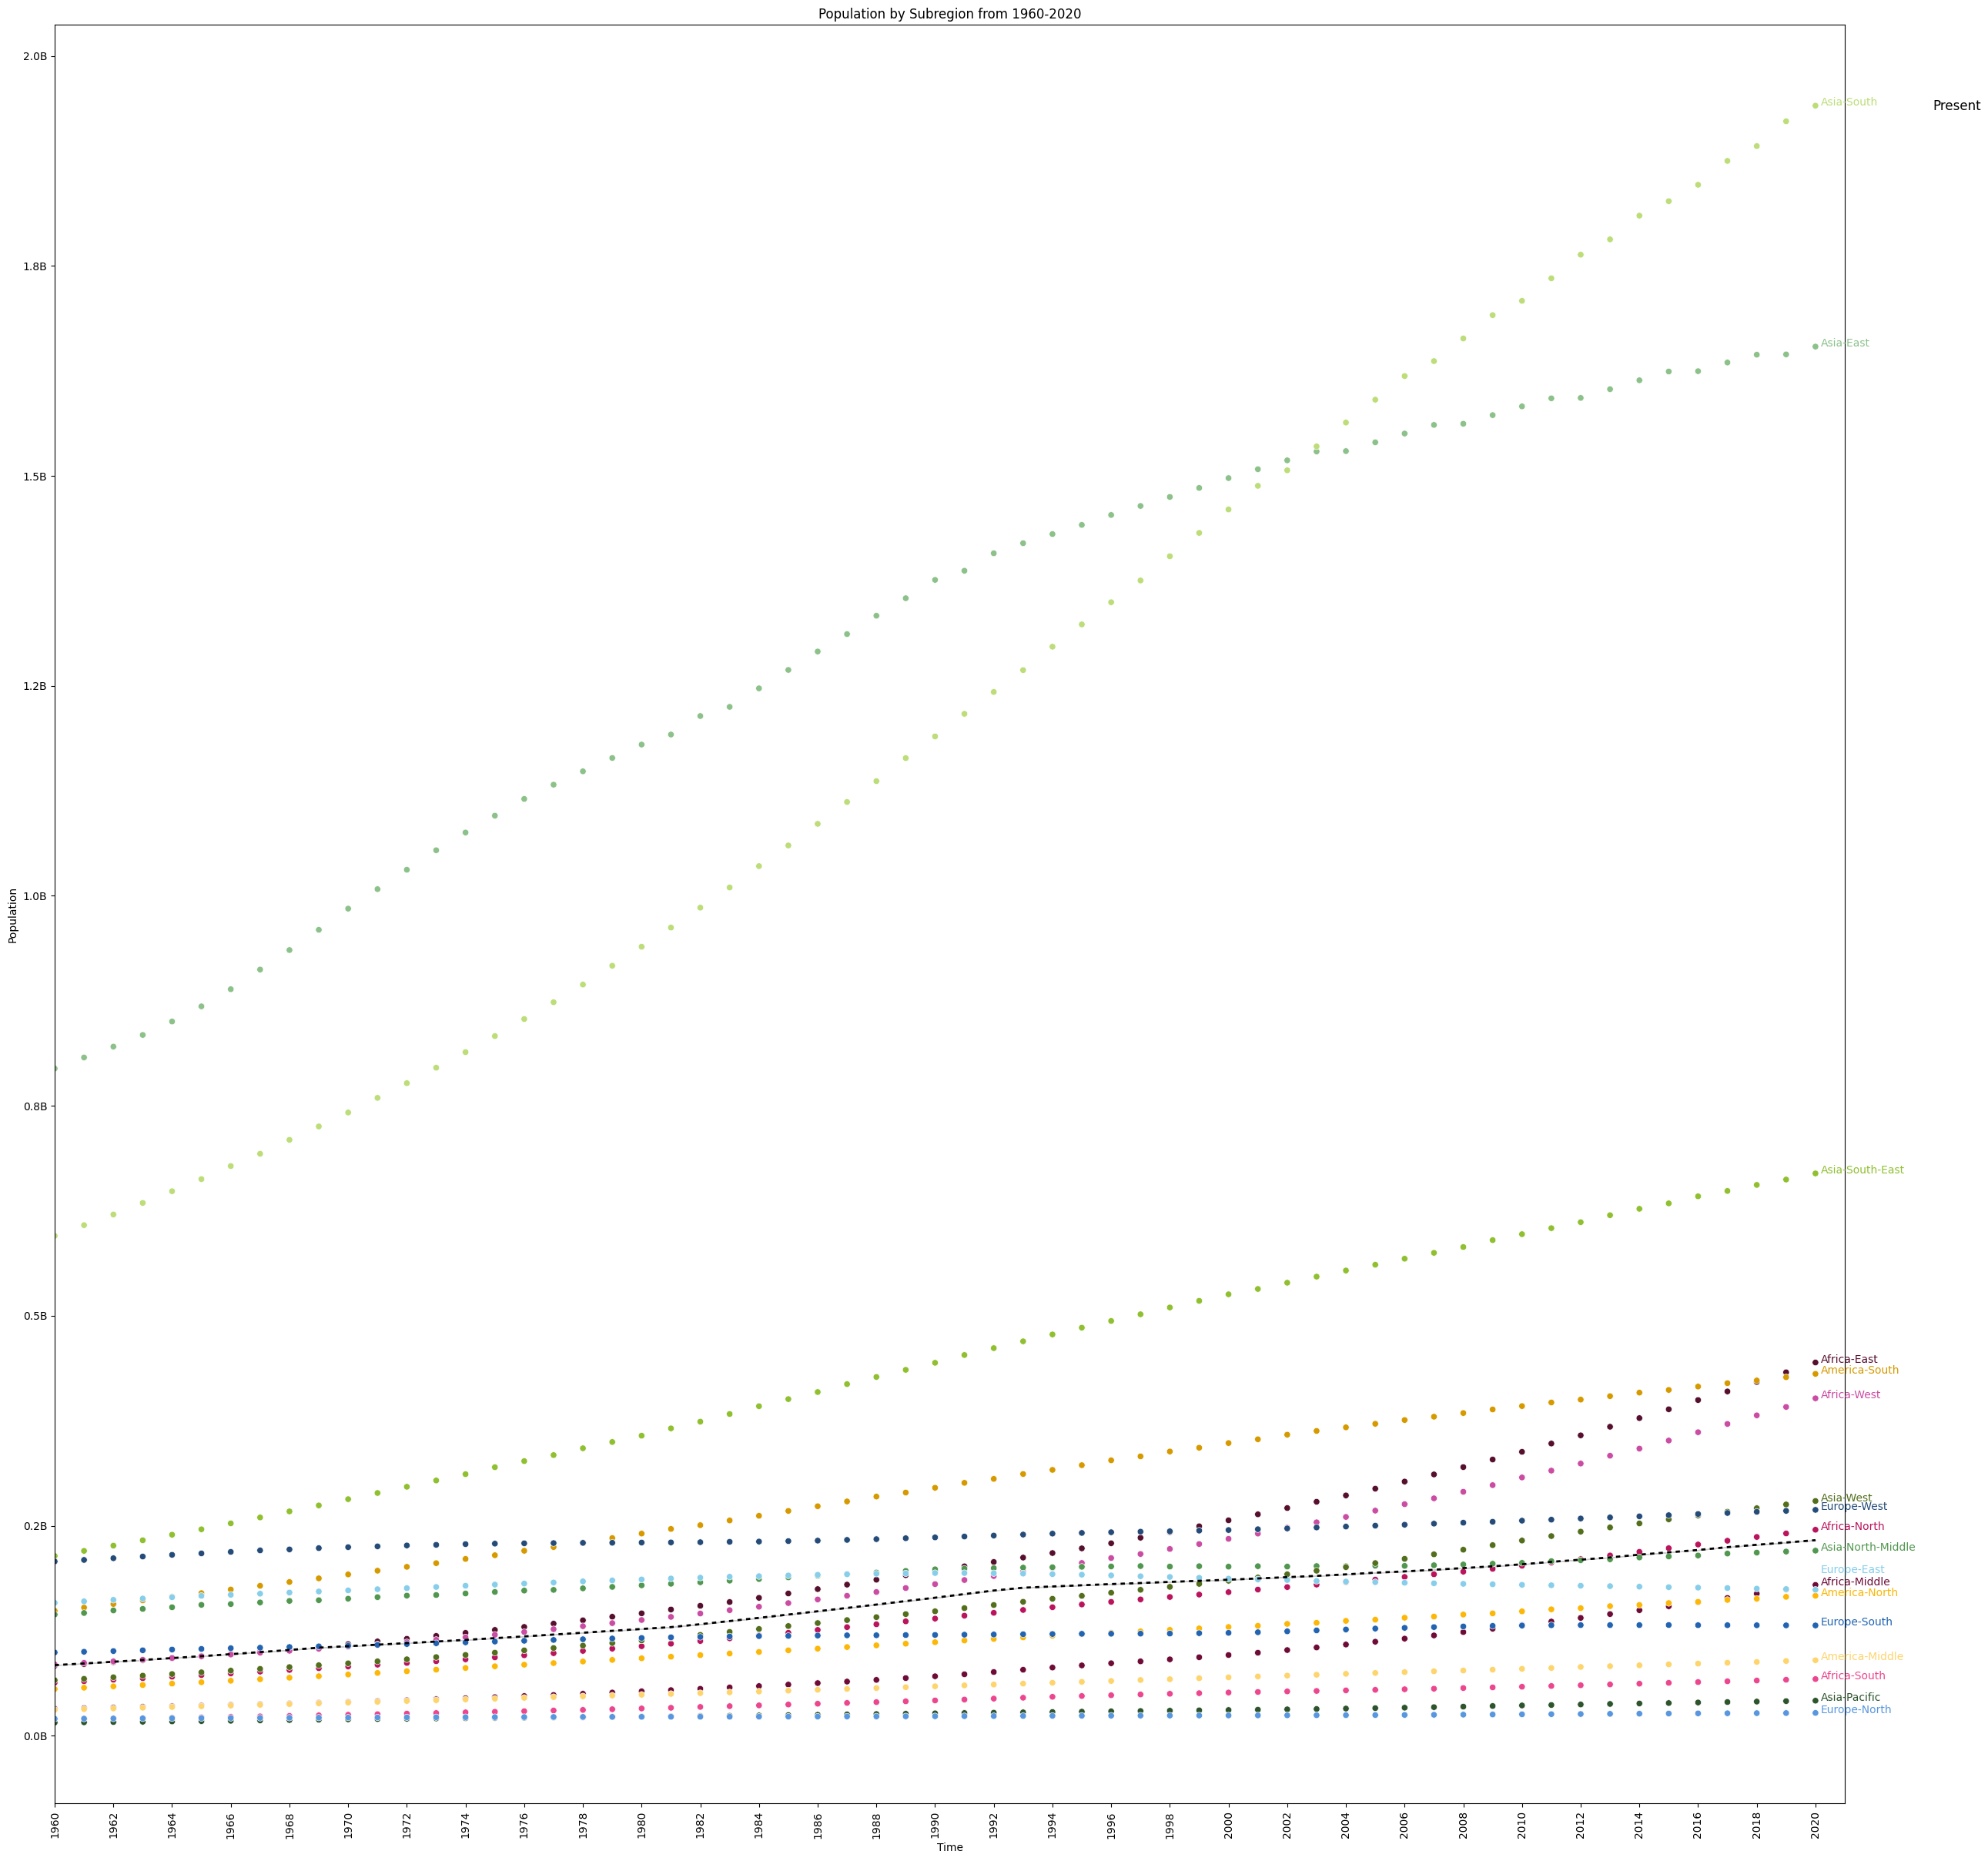

In [6]:
fig, ax = plt.subplots(nrows=1, figsize=(30, 30))

sns.lineplot(data=df, x='year', y='median_pop', color='black', ax=ax, dashes=[2,2], linewidth=2)

sns.scatterplot(
    data=df.loc[(df['year'] % 1 == 0)], x='year', y='pop',
    hue='subregion', palette=subregion_colors, alpha=1,
    legend=False, ax=ax)

ax.axvline(x=2023, color='gray', alpha=0.7, linestyle='--')
ax.text(2024, ax.get_ylim()[1]*0.95, 'Present', ha='left', fontsize=12, color='black')

for subregion in subregion_colors.keys():
    sub_df = df[df['subregion'] == subregion]
    plt.annotate(subregion, xy=(sub_df['year'].max(), sub_df['pop'].max()), xytext=(5, 0), textcoords="offset points", color=subregion_colors[subregion])

# format y-axis ticks as billions and millions
def billions_formatter(x, pos):
    return f'{x/1e9:.1f}B'
def millions_formatter(x, pos):
    return f'{x/1e6:.0f}M'
ax.set_xlim(1960, 2021)
ax.set_xticks(range(1960, 2021, 2))
ax.set_xticklabels(range(1960, 2021, 2), rotation=90)
ax.yaxis.set_minor_formatter(ticker.FuncFormatter(billions_formatter))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(billions_formatter))
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.set_title('Population by Subregion from 1960-2020')
plt.show()

### Fertility and Child Mortality Rate

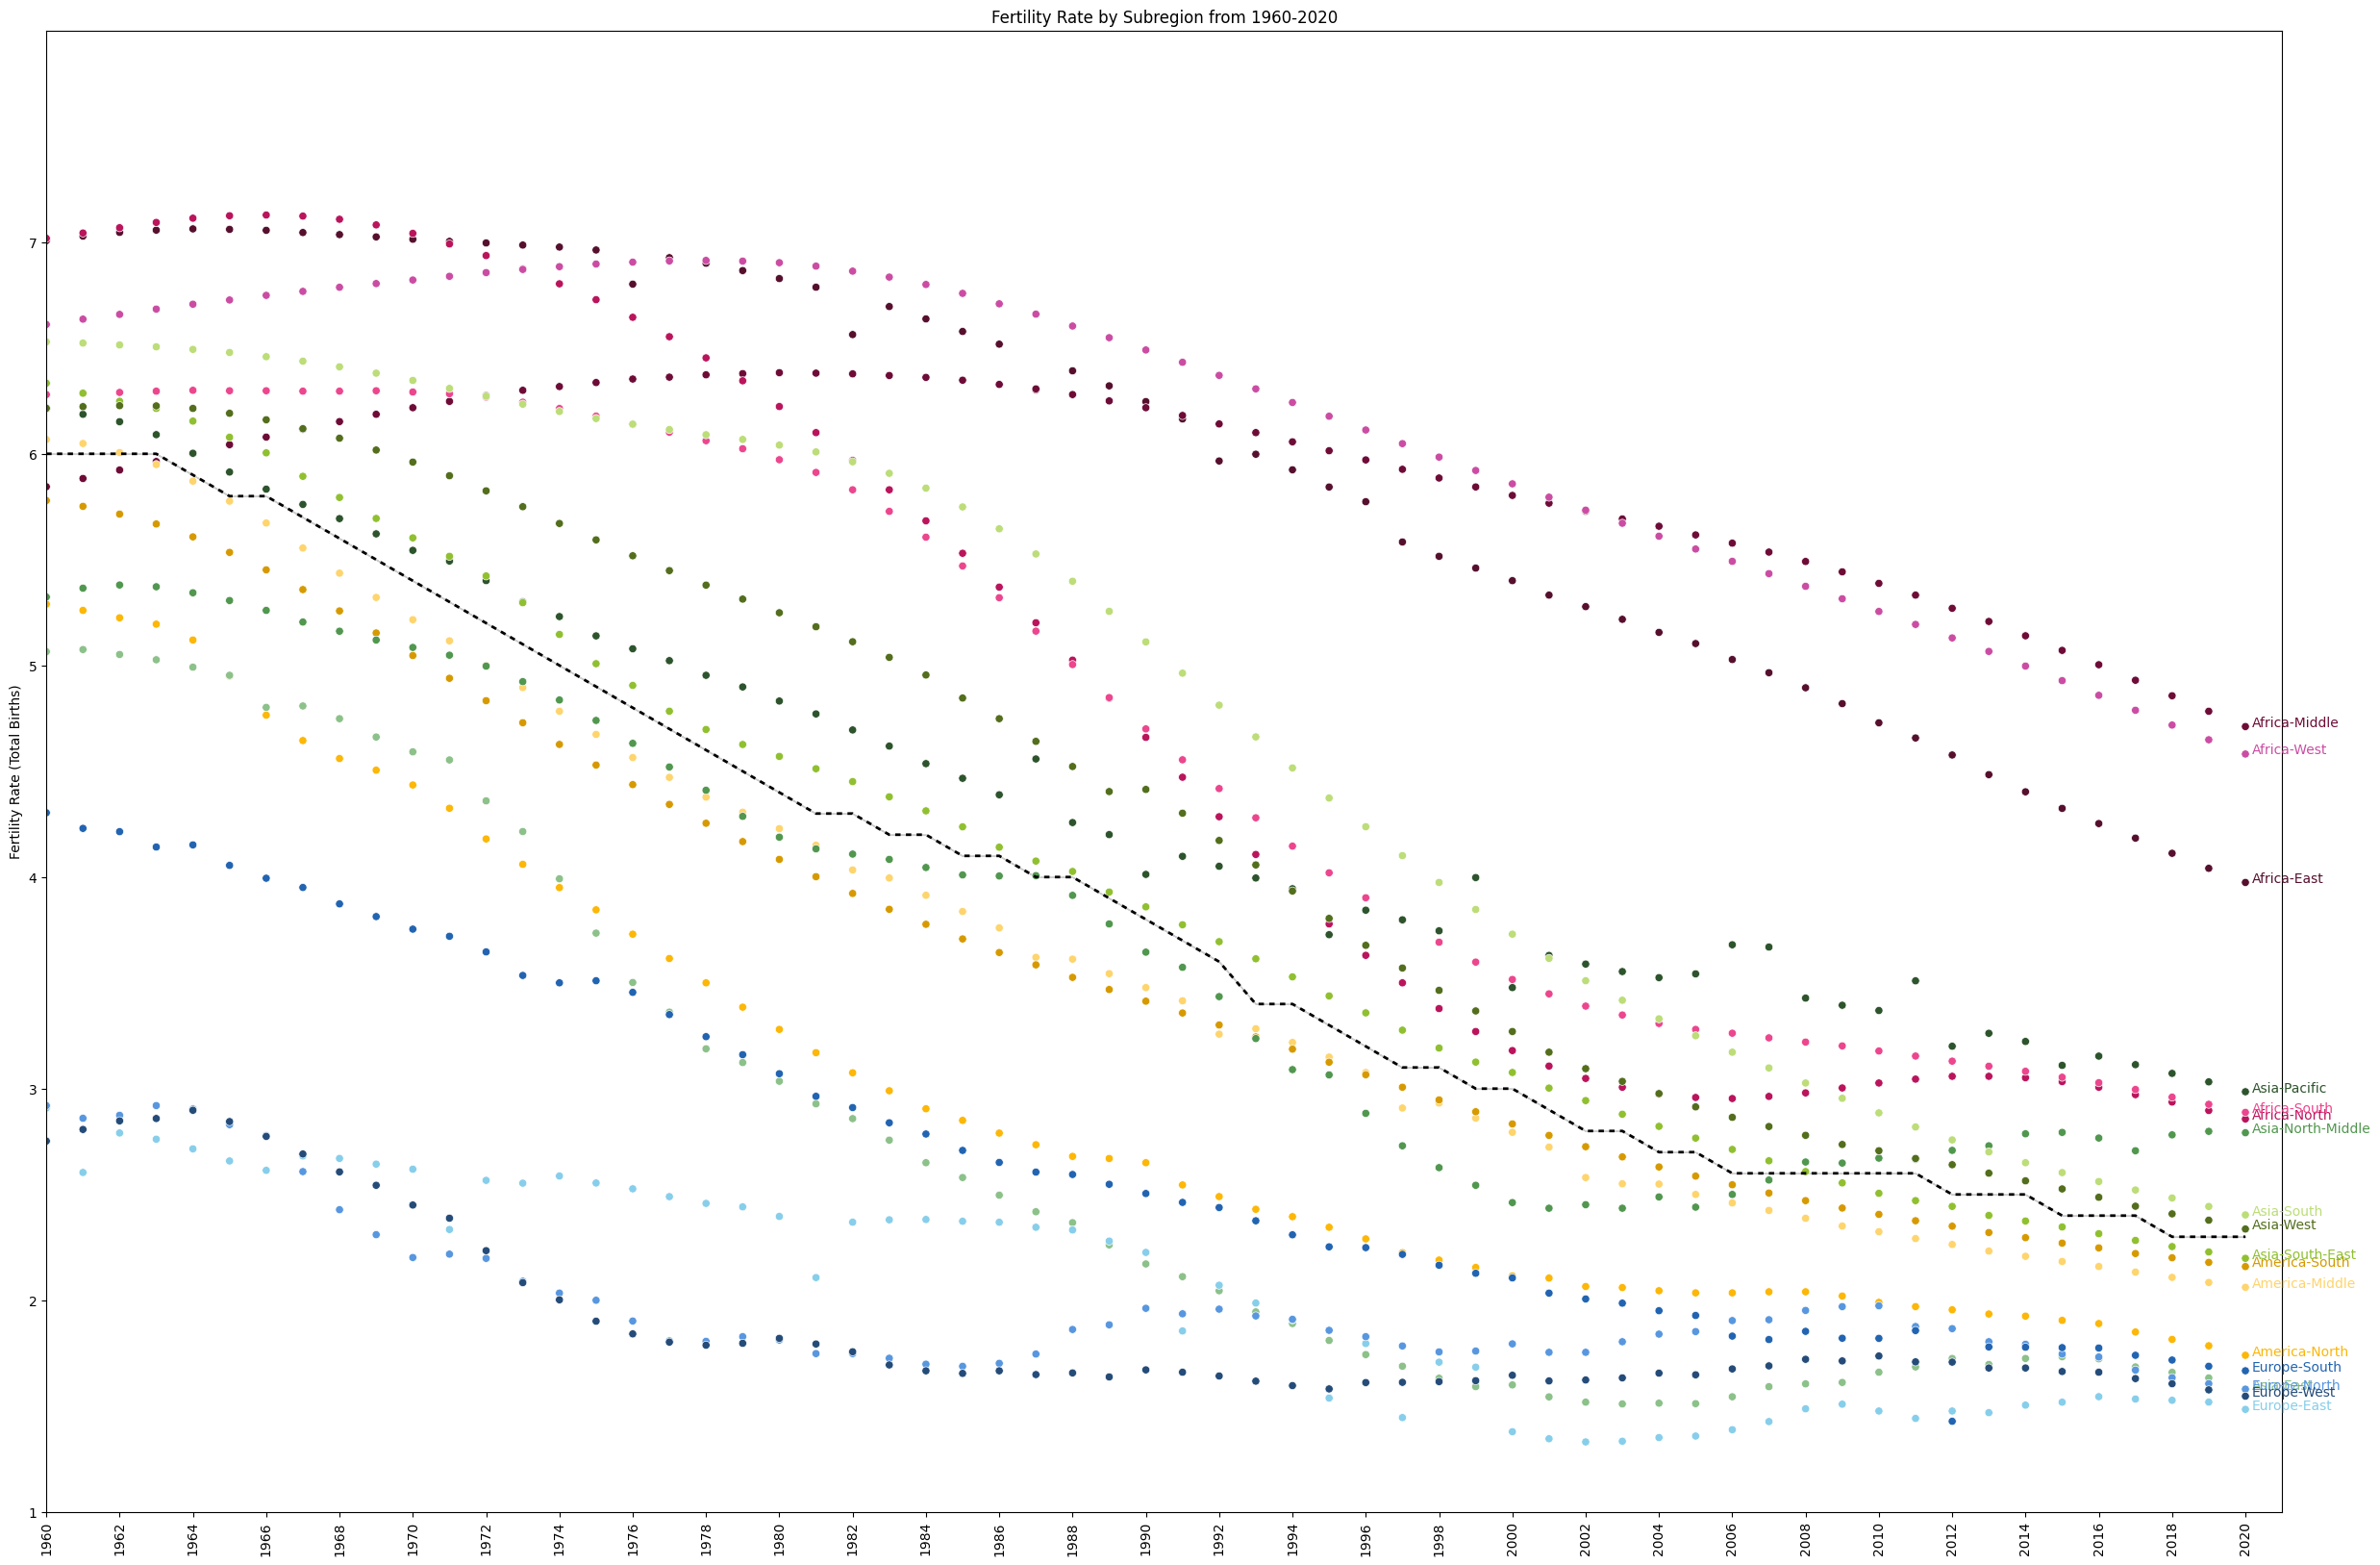

In [7]:
fig, ax = plt.subplots(nrows=1, figsize=(30, 20))

sns.lineplot(data=df, x='year', y='median_fert', color='black', ax=ax, dashes=[2,2], linewidth=2)

sns.scatterplot(
    data=df.loc[(df['year'] % 1 == 0)], x='year', y='fert_rate',
    hue='subregion', palette=subregion_colors, alpha=1,
    legend=False, ax=ax)

for subregion in subregion_colors.keys():
    sub_df = df[df['subregion'] == subregion]
    plt.annotate(subregion, xy=(sub_df['year'].max(), sub_df['fert_rate'].iloc[-1]), xytext=(5, 0), textcoords="offset points", color=subregion_colors[subregion])

ax.set_xlabel('')
ax.set_xlim(1960, 2021)
ax.set_xticks(range(1960, 2021, 2))
ax.set_xticklabels(range(1960, 2021, 2), rotation=90)

ax.set_ylabel('Fertility Rate (Total Births)')
ax.set_ylim(1, 8)
ax.set_yticks(range(1, 8, 1))

ax.set_title('Fertility Rate by Subregion from 1960-2020')
plt.show()

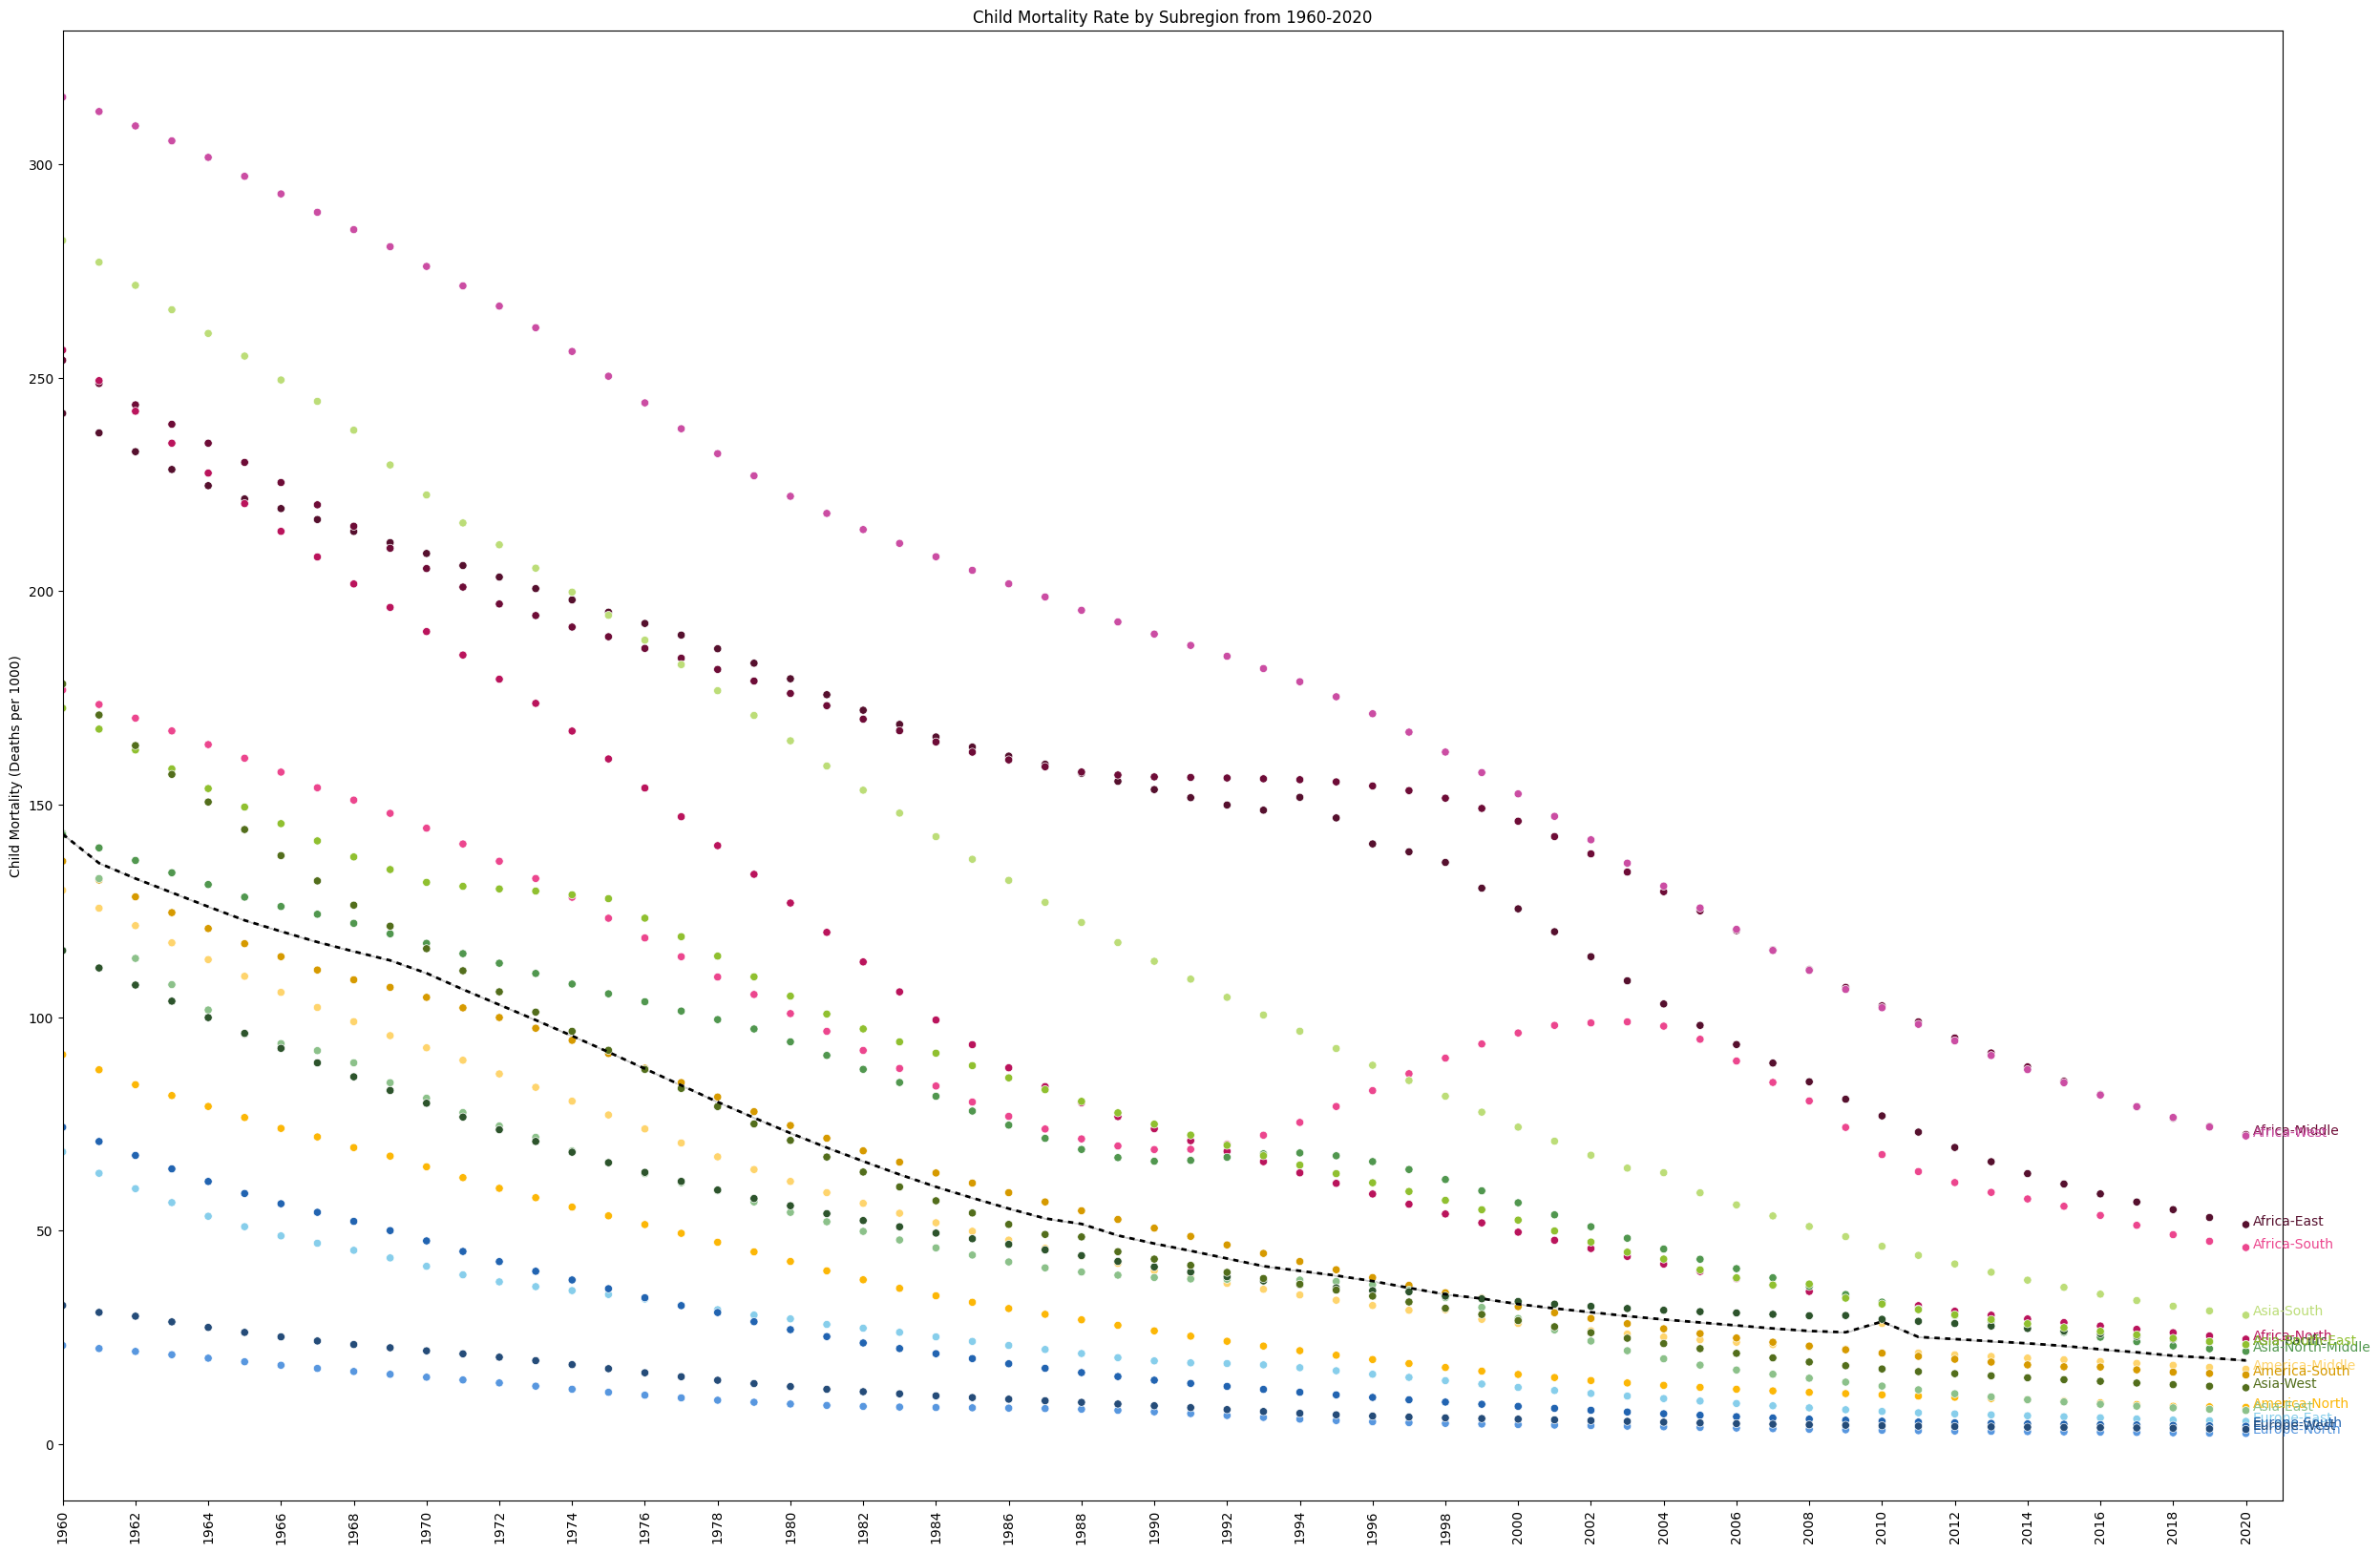

In [8]:
fig, ax = plt.subplots(nrows=1, figsize=(30, 20))

sns.lineplot(data=df, x='year', y='median_child', color='black', ax=ax, dashes=[2,2], linewidth=2)

sns.scatterplot(
    data=df.loc[(df['year'] % 1 == 0)], x='year', y='child_mort',
    hue='subregion', palette=subregion_colors, alpha=1,
    legend=False, ax=ax)

for subregion in subregion_colors.keys():
    sub_df = df[df['subregion'] == subregion]
    plt.annotate(subregion, xy=(sub_df['year'].max(), sub_df['child_mort'].iloc[-1]), xytext=(5, 0), textcoords="offset points", color=subregion_colors[subregion])

ax.set_xlabel('')
ax.set_xlim(1960, 2021)
ax.set_xticks(range(1960, 2021, 2))
ax.set_xticklabels(range(1960, 2021, 2), rotation=90)

ax.set_ylabel('Child Mortality (Deaths per 1000)')

ax.set_title('Child Mortality Rate by Subregion from 1960-2020')
plt.show()

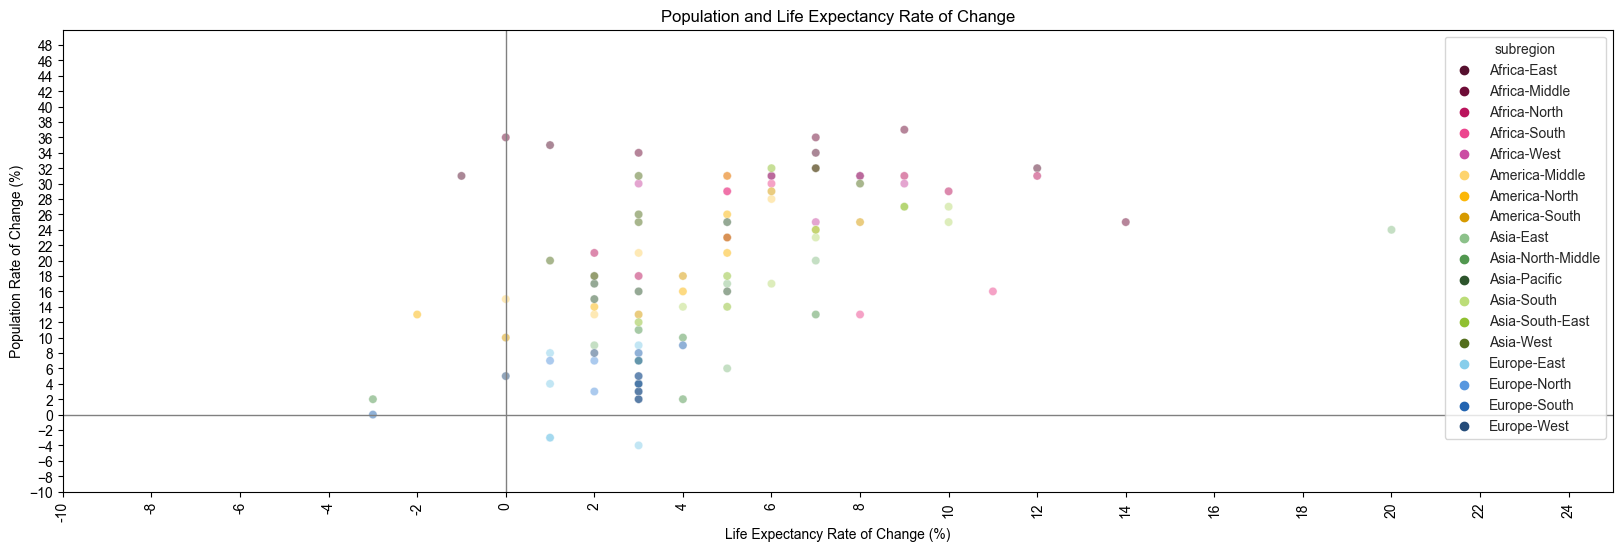

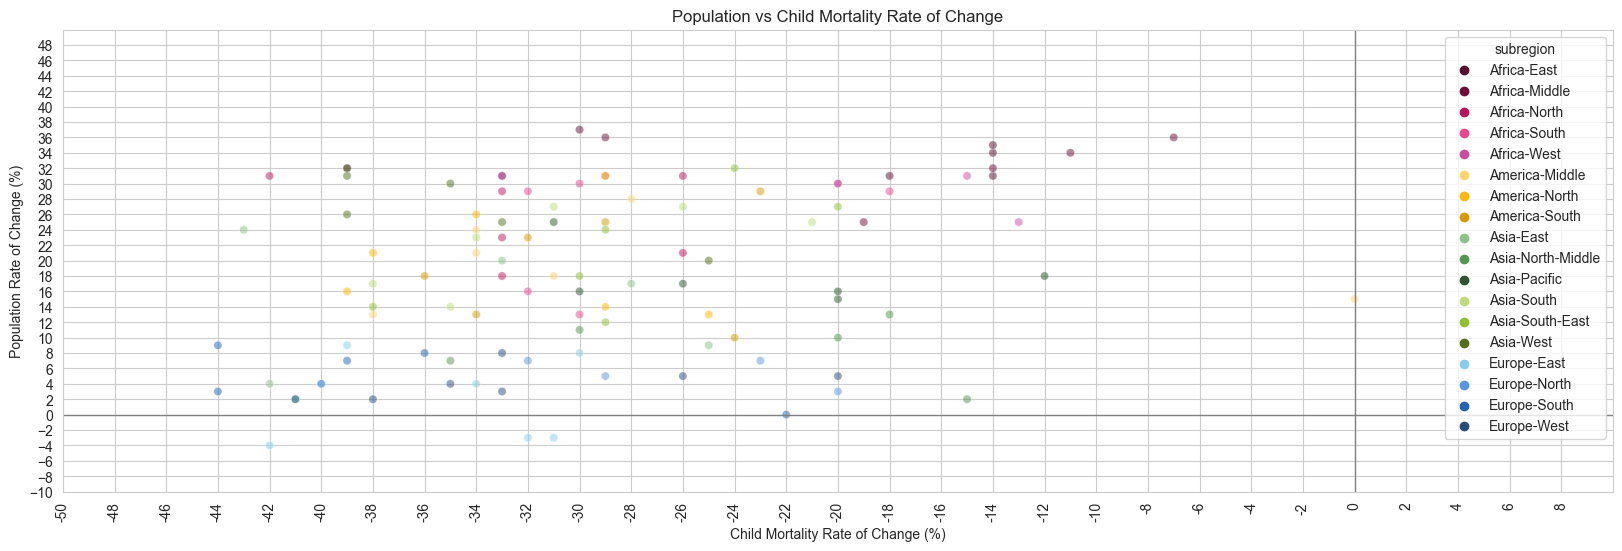

In [9]:
df_10y = df[df['year'] % 10 == 0]
df_10y['life_pct'] = round(df_10y.groupby('subregion')['life'].pct_change(),2) * 100
df_10y['pop_pct'] = round(df_10y.groupby('subregion')['pop'].pct_change(),2)*100
df_10y['child_pct'] = round(df_10y.groupby('subregion')['child_mort'].pct_change(),2)*100
df_10y['fert_pct'] = round(df_10y.groupby('subregion')['fert_rate'].pct_change(),2)*100

fig, ax = plt.subplots(nrows=1, figsize=(20, 6))
sns.set_style('whitegrid')
sns.scatterplot(data=df_10y[(df_10y['life_pct'].notna())&(df_10y['pop_pct'].notna())], x='life_pct', y='pop_pct', hue='subregion', palette=subregion_colors, alpha=0.5, ax=ax)
ax.set_xticks(range(-10, 25, 2))
ax.set_xticklabels(range(-10, 25, 2),rotation=90)
ax.set_yticks(range(-10, 50, 2))
ax.set_xlim(-10, 25)
ax.set_ylim(-10, 50)
ax.set_xlabel('Life Expectancy Rate of Change (%)')
ax.set_ylabel('Population Rate of Change (%)')
ax.set_title('Population and Life Expectancy Rate of Change')
ax.axhline(0, color='gray', linewidth=1)
ax.axvline(0, color='gray', linewidth=1)
plt.show()


fig, ax = plt.subplots(nrows=1, figsize=(20, 6))
sns.set_style('whitegrid')
sns.scatterplot(data=df_10y[(df_10y['child_pct'].notna())&(df_10y['pop_pct'].notna())], x='child_pct', y='pop_pct', hue='subregion', palette=subregion_colors, alpha=0.5, ax=ax)

ax.set_xlabel('Child Mortality Rate of Change (%)')
ax.set_xticks(range(-50,10,2))
ax.set_xticklabels(range(-50,10,2),rotation=90)
ax.set_xlim(-50,10)

ax.set_ylabel('Population Rate of Change (%)')
ax.set_ylim(-10,50)
ax.set_yticks(range(-10,50,2))
ax.axhline(0, color='gray', linewidth=1)
ax.axvline(0, color='gray', linewidth=1)
ax.set_title('Population vs Child Mortality Rate of Change')
plt.show()


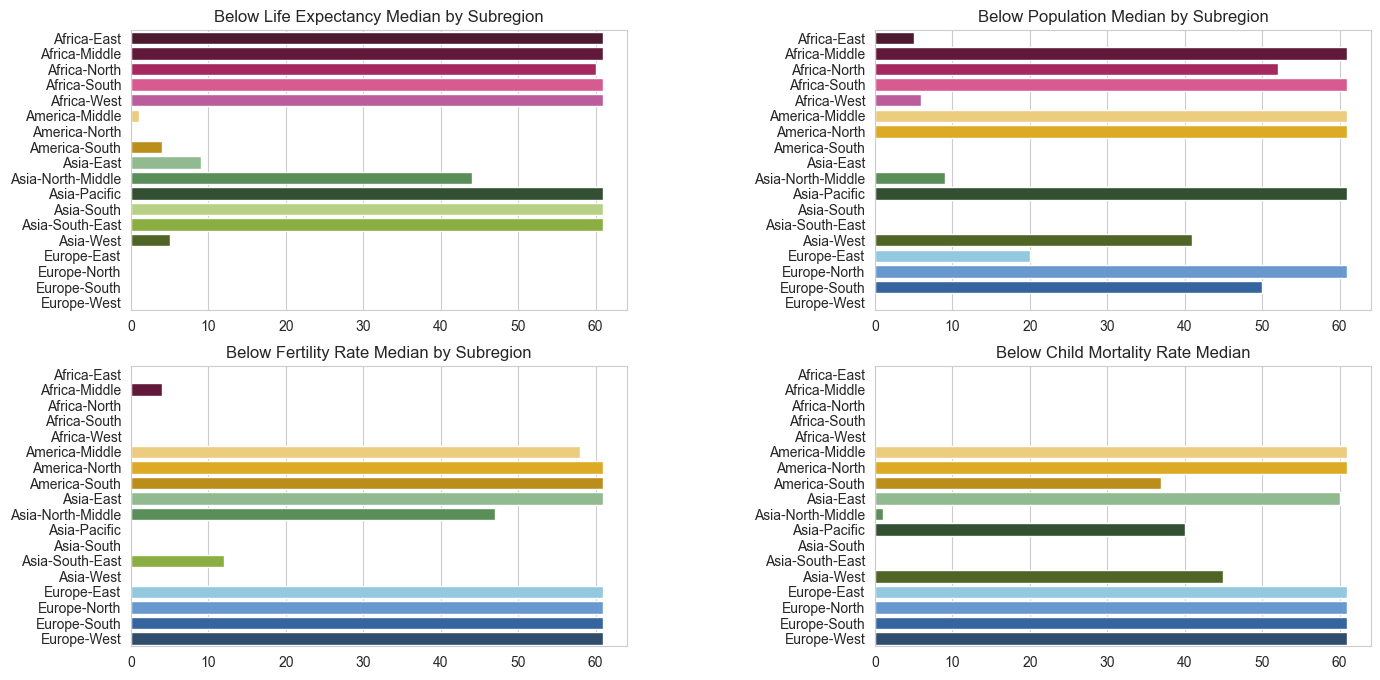

In [10]:
grouped_life_cat = df.groupby(['subregion', 'below_life'])['below_life'].count().unstack()
grouped_pop_cat = df.groupby(['subregion', 'below_pop'])['below_pop'].count().unstack()
grouped_fert_cat = df.groupby(['subregion', 'below_fert'])['below_fert'].count().unstack()
grouped_child_cat = df.groupby(['subregion', 'below_child'])['below_child'].count().unstack()

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
sns.barplot(data=grouped_life_cat, x=1, y=grouped_life_cat.index, orient='h', palette=subregion_colors, ax=axs[0,0], order=grouped_life_cat.index)
axs[0,0].set_title('Below Life Expectancy Median by Subregion')
axs[0,0].set_xlabel('')
axs[0,0].set_ylabel('')
sns.barplot(data=grouped_pop_cat, x=1, y=grouped_pop_cat.index, orient='h', palette=subregion_colors, ax=axs[0,1], order=grouped_pop_cat.index)
axs[0,1].set_title('Below Population Median by Subregion')
axs[0,1].set_xlabel('')
axs[0,1].set_ylabel('')
sns.barplot(data=grouped_fert_cat, x=1, y=grouped_fert_cat.index, orient='h', palette=subregion_colors, ax=axs[1,0], order=grouped_fert_cat.index)
axs[1,0].set_title('Below Fertility Rate Median by Subregion')
axs[1,0].set_xlabel('')
axs[1,0].set_ylabel('')
sns.barplot(data=grouped_child_cat, x=1, y=grouped_child_cat.index, orient='h', palette=subregion_colors, ax=axs[1,1], order=grouped_child_cat.index)
axs[1,1].set_title('Below Child Mortality Rate Median')
axs[1,1].set_xlabel('')
axs[1,1].set_ylabel('')

plt.subplots_adjust(wspace=0.5)
plt.show()

## Data Analysis

*Writing soon*

## Extras: Animating Trends 🖼️

Here is a code snippet that creates an animated scatterplot using Matplotlib and Seaborn libraries, which can be easily customized to visualize trends in any two-dimensional dataset with a temporal dimension

![Life Expectancy vs Fertility Rate](./output/life_expectancy_vs_fertility_rate.gif)

MovieWriter imagemagick unavailable; using Pillow instead.


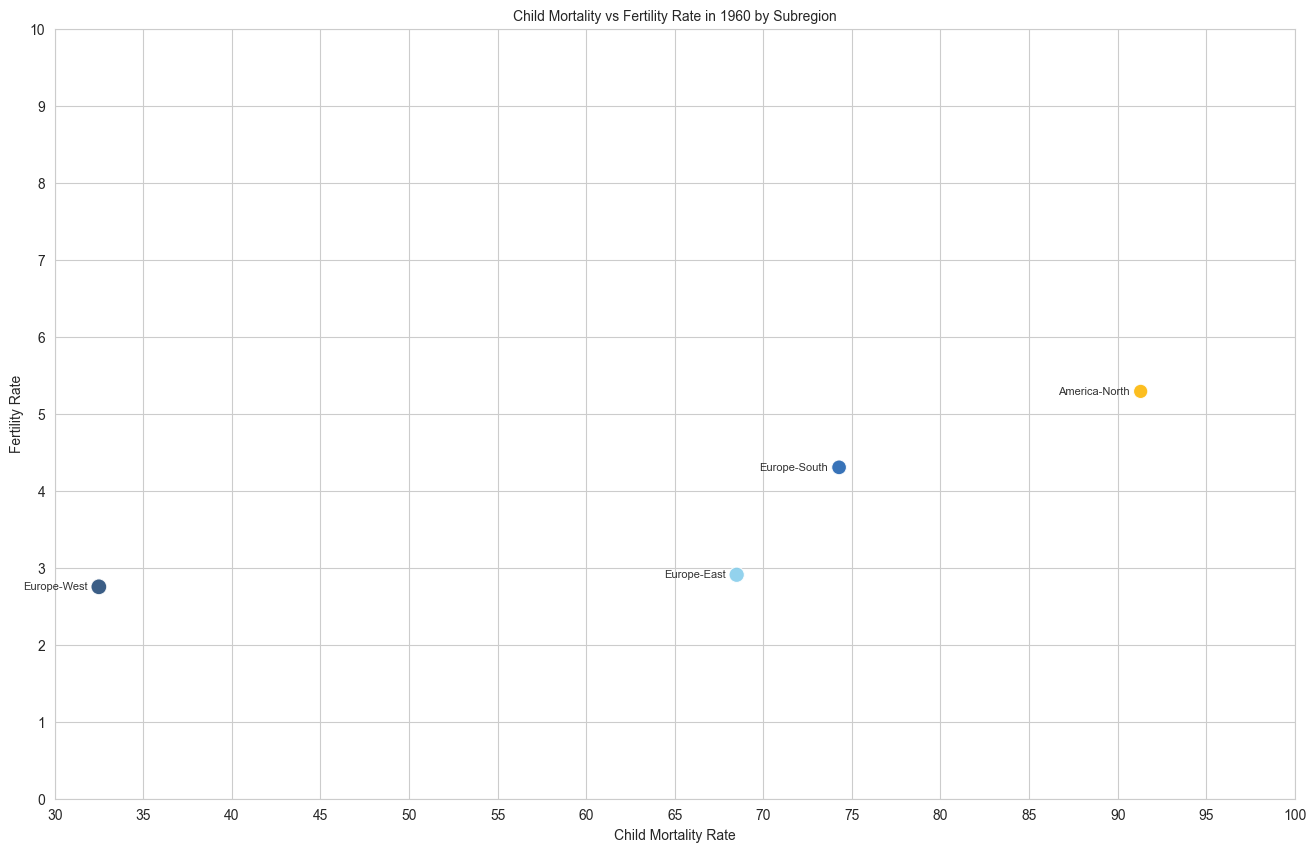

In [12]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(16, 10))
sns.set_style('whitegrid')

def update(year):
    ax.clear()
    sns.scatterplot(data=df, x=df.loc[df['year']==year]['child_mort'], y=df.loc[df['year']==year]['fert_rate'],
                    hue='subregion', size='pop', sizes=(100, 400), alpha=0.9, ax=ax, palette=subregion_colors, legend=False)
    for index, row in df.loc[df['year']==year].iterrows():
        ax.annotate(row['subregion'], (row['child_mort'], row['fert_rate']), textcoords="offset points", xytext=(-8,0), ha='right', va='center', 
                fontsize=8, color='black', alpha=0.8)
    ax.set_title(f'Child Mortality vs Fertility Rate in {year} by Subregion', fontsize='medium')
    ax.set_xlabel('Child Mortality Rate')
    ax.set_ylabel('Fertility Rate')
    ax.set_xlim(30, 100)
    ax.set_ylim(0, 10)
    ax.set_yticks(range(0, 11, 1))
    ax.set_xticks(range(30, 101, 5))

ani = animation.FuncAnimation(fig, update, frames=range(1960, 2021), interval=10000)
ani.save('output/fertility_vs_child_mortality_rate.gif', writer='imagemagick', fps=12, dpi=72)

## Resources

*Writing soon*